In [1]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
from collections import defaultdict
from bs4 import BeautifulSoup  
import requests
import zipfile
import io
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#from nltk.tokenize import word_tokenize
nltk.download('stopwords')

#import geopandas as gpd|
#import shapely
import gensim
import tqdm
import tensorflow as tf
import keras

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding

import sys

path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))

google_colab = 0
if google_colab == 1:
    from google.colab import drive
    drive.mount('/content/drive/')
    path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/"
    
sys.path.insert(0, path_folder+"/src/features/")
import util

from word2vec_recipe import *

import tqdm
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.__version__

'1.3.5'

In [3]:
from keras.applications.vgg16 import VGG16
#vggnet_model = VGG16()
pics_link_header = "https://lh5.googleusercontent.com/p/"
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from PIL import Image
import requests
from io import BytesIO

from sklearn.preprocessing import LabelEncoder


In [4]:
import string

In [5]:
USING_SPARK = 0
SPARK_SESSION_VERSION = 1
if USING_SPARK == 1:
    import findspark
    import pyspark
    import pyspark.sql.functions as F
    import pyspark.sql.types as T
    import pyspark.ml as M
    from pyspark.sql.window import Window
    from pyspark.sql import SparkSession
    findspark.init()
    if SPARK_SESSION_VERSION == 1:
        spark = SparkSession.builder.getOrCreate()
    elif SPARK_SESSION_VERSION == 2:
        spark = SparkSession.builder \
            .master('local[*]') \
            .config("spark.driver.memory", "3g") \
            .appName('food_rec') \
            .getOrCreate()
    

In [6]:
class Reviews_Dataset_Reader:
    def __init__(self, 
                 path_folder,
                 dataset_version = "FULL",
                 using_pics = 0,
                 using_spark = 0,
                 drop_double_one_time_appearances = 1,
                 drop_separate_one_time_appearances = 0,
                ):
        assert dataset_version in ["FULL", "FILTER"]
        assert using_pics in [0,1]    
        #self.path_folder = path_folder
        self.dataset_version = dataset_version
        self.using_pics = using_pics
        if self.using_pics == 1:
            self.dataset_version = "FILTER"
            self.vggnet_model = VGG16()
            self.pic_link_header = "https://lh5.googleusercontent.com/p/"
        self.using_spark = using_spark
        self.drop_double_one_time_appearances = drop_double_one_time_appearances
        self.drop_separate_one_time_appearances = drop_separate_one_time_appearances
        if self.dataset_version == "FULL":
            file_name_data = "image_review_all.json"
        if self.dataset_version == "FILTER":
            file_name_data = "filter_all_t.json"
        self.path_folder_data = os.path.join(path_folder,"data","raw",file_name_data)

    def get_pics_words_from_links(self, pic_links, top_n=10):
        pics_len = len(pic_links)
        vggnet_model_input = []
        for i in (range(0, pics_len)):
            try:
                temp_pic_link = pic_links[i]
                temp_pic_link = self.pic_link_header + temp_pic_link
                response = requests.get(temp_pic_link)
                image = Image.open(BytesIO(response.content))
                image = np.array(image)
                image =  np.array(Image.fromarray(image).resize((224, 224), Image.NEAREST))
                assert image.shape == (224, 224, 3)
                vggnet_model_input.append(image)
            except:
                pass
        vggnet_model_input = np.array(vggnet_model_input)
        if vggnet_model_input.size == 0:
            return []
        #print(vggnet_model_input.shape)
        assert list(vggnet_model_input.shape)[-3:] == [224, 224, 3]
        assert len(vggnet_model_input.shape) == 4
        #assert len(unbroken_indices) == vggnet_model_input.shape[0]
        encoded_predictions = self.vggnet_model.predict(vggnet_model_input) #, verbose=0)
        decoded_output = decode_predictions(encoded_predictions)
        
        pics_words = []
        for decoded_i in range(len(decoded_output)):
            pic_words = [label[1] for label in decoded_output[decoded_i][:top_n]]
            pics_words += pic_words
            # assert len(pics_words) > 0
        return pics_words
    def get_review_info(self, review):
        temp_business_id = None
        temp_user_id = None
        temp_rating = None
        temp_review_text = None
        temp_pics = None

        if "business_id" in review:
            temp_business_id = review["business_id"]
        if "user_id" in review:
            temp_user_id = review["user_id"]
        if "rating" in review:
            temp_rating = review["rating"]
        if "review_text" in review:
            temp_review_text = review["review_text"]
        if "pics" in review:
            temp_pics = review["pics"]
            if self.dataset_version == "FULL":
                temp_pics = [x["id"] for x in (temp_pics)]

        if self.using_pics == 1:
            if (temp_pics is None)==False:
                temp_pics_words = self.get_pics_words_from_links(temp_pics)
                if temp_review_text is None:
                    temp_review_text = ""
                temp_review_text += (" " + " ".join(temp_pics_words))
        return (temp_business_id, temp_user_id, temp_rating, temp_review_text)
    def build_reviews_df(self):
        
        raw_data_orig = []
        with open(self.path_folder_data) as f:
            for line in tqdm.tqdm(f):
                raw_data_orig.append(eval(line))
            f.close()
            
        assert len(raw_data_orig) == 1
        #print(raw_data_orig[0].keys())

        if self.dataset_version in ["FILTER"]:
            raw_data_train = (raw_data_orig[0]["train"])
            raw_data_val = (raw_data_orig[0]["val"])
            raw_data_test = (raw_data_orig[0]["test"])
            raw_data_sources = [raw_data_train, raw_data_val, raw_data_test]
        else:
            raw_data = raw_data
            raw_data_sources = [raw_data]
        
        reviews_df_business_id_column_list = []
        reviews_df_user_id_column_list = []
        reviews_df_rating_column_list = []
        reviews_df_review_text_column_list = []
        
        for raw_data_source in raw_data_sources:
            for review in tqdm.tqdm(raw_data_source):
                temp_business_id, temp_user_id, temp_rating, temp_review_text = self.get_review_info(review)

                reviews_df_business_id_column_list.append(temp_business_id)
                reviews_df_user_id_column_list.append(temp_user_id)
                reviews_df_rating_column_list.append(temp_rating)
                reviews_df_review_text_column_list.append(temp_review_text)            

        reviews_df = pd.DataFrame()
        reviews_df["business_id"] = reviews_df_business_id_column_list
        reviews_df["user_id"] = reviews_df_user_id_column_list
        reviews_df["rating"] = reviews_df_rating_column_list
        reviews_df["review_text"] = reviews_df_review_text_column_list  
        
        business_id_label_encoder = LabelEncoder()
        user_id_label_encoder = LabelEncoder()

        business_id_label_encoder.fit(reviews_df["business_id"])
        user_id_label_encoder.fit(reviews_df["user_id"])

        reviews_df["business_id"] = business_id_label_encoder.transform(reviews_df["business_id"])
        reviews_df["user_id"] = user_id_label_encoder.transform(reviews_df["user_id"])
        self.reviews_df = reviews_df
        return reviews_df
    def convert_df_to_spark(self, reviews_df=None):
        if word2vec_df is None:
            reviews_df = self.reviews_df
        
        if self.using_spark == 1:
            reviews_df["review_text"].fillna("_",inplace=True)
            schema = T.StructType([
                T.StructField("business_id", T.IntegerType(), True),
                T.StructField("user_id", T.IntegerType(), True),
                T.StructField("rating", T.IntegerType(), True),
                T.StructField("review_text", T.StringType(), True)]
            )
            reviews_df = spark.createDataFrame(reviews_df, schema)        
        else:
            raise Exception("Spark is disabled; cannot convert dataframe to spark")
        
        self.reviews_df = reviews_df
        
        return reviews_df

In [7]:
vocab_column_names = ["ingredients"]+["name"]
file_name_word2vec = "word2vec_"+("_".join(vocab_column_names))+".pkl"
path_file_word2vec = os.path.join(path_folder, "data","temp",file_name_word2vec)
with open(path_file_word2vec, "rb") as f:
    recipe_word2vec = pickle.load(f)

vocab_column_names = ["ingredients"]#+["name"]
file_name_tfidf = "tfidf_"+("_".join(vocab_column_names))+".pkl"
path_file_tfidf = os.path.join(path_folder, "data","temp",file_name_tfidf)
with open(path_file_tfidf, "rb") as f:
    recipe_tfidf = pickle.load(f)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
DATASET_VERSION = ["FULL", "FILTER"][1]  
DROP_ONE_TIME_APPEARANCES = 1
DROP_SEPARATED_ONE_TIME_APPEARANCES = 0
USING_PICS = 0

In [9]:
reviews_dataset_reader = Reviews_Dataset_Reader(
    path_folder, 
    DATASET_VERSION, 
    USING_PICS,
    USING_SPARK,
    DROP_ONE_TIME_APPEARANCES, 
    DROP_SEPARATED_ONE_TIME_APPEARANCES,
)

In [10]:
_ = reviews_dataset_reader.build_reviews_df()

1it [00:10, 10.05s/it]
100%|████████████████████████████████████████████████████████████████████████| 11015/11015 [00:00<00:00, 523575.01it/s]


In [11]:
reviews_df = reviews_dataset_reader.reviews_df

In [12]:
stop_words = stopwords.words('english')
lexicon = [word for word in recipe_tfidf.vocab2idx if word not in stop_words]

In [13]:
class Word2vec_Dataset_Reader:
    def __init__(self, 
                 word2vec_model, 
                 lexicon, 
                 vector_mode="COMPRESSED",
                 using_spark=0,
                ):
        assert vector_mode in ["COMPRESSED","SPLIT"]
        self.word2vec_model = word2vec_model
        self.lexicon = lexicon
        self._vector_mode = vector_mode
        embedding_size = self.word2vec_model.vector_size
        if self._vector_mode == "COMPRESSED":
            self.vec_column_names = ["vec"]
        elif self._vector_mode == "SPLIT":
            self.vec_column_names = ["v{0}".format(i) for i in range(embedding_size)]
        self.using_spark = using_spark
    def build_word2vec_df(self):
        word2vec_vocab = self.word2vec_model.wv.vocab
        vocab = [word for word in word2vec_vocab if (word in self.lexicon)]
        vecs = [self.word2vec_model.wv[word] for word in vocab]
        vecs_arr = np.array(vecs)
        
        word2vec_df = pd.DataFrame()
        word2vec_df["review_text"] = vocab
        vec_column_names = self.vec_column_names
        vector_mode = self._vector_mode
        if vector_mode == "COMPRESSED":
            word2vec_df[vec_column_names[0]] = vecs
        elif vector_mode == "SPLIT":
            for i in range(len(vec_column_names)):
                vec_column_name = vec_column_names[i]
                word2vec_df[vec_column_name] = vecs_arr[:, i]
        self.word2vec_df = word2vec_df
        return word2vec_df
    def convert_df_to_spark(self, word2vec_df=None):
        if word2vec_df is None:
            word2vec_df = self.word2vec_df
        vector_mode = self.vector_mode
        vec_column_names = self.vec_column_names
        if self.using_spark == 1:
            if vector_mode == "COMPRESSED":
                schema = T.StructType([
                    T.StructField("review_text", T.StringType(), True)
                ]+[T.StructField(vec_column_names[0],T.ArrayType(T.DoubleType()), True)]
                )
            elif vector_mode == "SPLIT":
                schema = T.StructType([
                    T.StructField("review_text", T.StringType(), True)
                ]+[T.StructField(c, T.DoubleType(), True) for c in vec_column_names]
                )
            word2vec_df = spark.createDataFrame(word2vec_df, schema)
        else:
            raise Exception("Spark is disabled; cannot convert dataframe to spark")
        self.word2vec_df = word2vec_df
        return word2vec_df

In [14]:
word2vec_dataset_reader = Word2vec_Dataset_Reader(
    recipe_word2vec,
    lexicon,
)
word2vec_df = word2vec_dataset_reader.build_word2vec_df()

In [15]:
# pretend the filt was stacked with train test and pics words added already

In [16]:
# PANDAS VERSION

def clean_text_column(text_column):
    non_alphanumeric = string.punctuation # constant
    text_column = text_column.str.lower()
    text_column = text_column.str.translate(str.maketrans(non_alphanumeric, " "*len(non_alphanumeric)))
    return text_column

temp_df = reviews_df
temp_df["review_id"] = np.arange(temp_df.shape[0])
id_df = temp_df[["user_id","business_id","review_id"]]
review_df = temp_df[["review_id","review_text"]]

In [17]:
review_df["review_text"] = clean_text_column(review_df["review_text"]).str.split(" ")

reviewTextWords_df = review_df.explode("review_text")

print(len(reviewTextWords_df))

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


3095788


In [18]:
reviewTextWords_df = reviewTextWords_df[~(reviewTextWords_df["review_text"].isin(stop_words))]
reviewTextWords_df = reviewTextWords_df[(reviewTextWords_df["review_text"].isin(recipe_word2vec.wv.vocab))]
reviewTextWords_df = reviewTextWords_df[(reviewTextWords_df["review_text"].isin(recipe_tfidf.vocab2idx))]
reviewTextWords_df = reviewTextWords_df[(reviewTextWords_df["review_text"] != "")]
# remove words 

In [19]:
review_df = review_df[(review_df["review_id"].isin(pd.unique(reviewTextWords_df["review_id"])))]
# Remove double singletons

business_id_frequency = id_df.groupby(["business_id"],as_index=False).agg({"business_id": "count"}).reset_index()
business_id_frequency.rename(columns={"business_id":"count", "index": "business_id"},inplace=True)
#business_id_frequency = id_df["business_id"].value_counts().reset_index(name='count')
user_id_frequency = id_df.groupby(["user_id"],as_index=False).agg({"business_id": "count"}).reset_index()
user_id_frequency.rename(columns={"user_id":"count", "index": "user_id"},inplace=True)

#user_id_frequency = id_df["user_id"].value_counts().reset_index(name='count')
one_time_business_id_list = business_id_frequency[business_id_frequency["count"] == 1]["business_id"]
one_time_user_id_list = user_id_frequency[user_id_frequency["count"] == 1]["user_id"]

if DROP_ONE_TIME_APPEARANCES == True:
    id_df = id_df[
        ~( (id_df["business_id"].isin(one_time_business_id_list)) & (id_df["user_id"].isin(one_time_user_id_list)))
    ]
del business_id_frequency
del user_id_frequency
del one_time_business_id_list
del one_time_user_id_list

In [20]:
reviewTextWords_df["word_count"] = 1
#reviewTextWord2vec_df = reviewTextWords_df.merge(word2vec_df, on=["review_text"])
reviewTextWords_df.sort_values(["review_id"], inplace=True)
id_review_df = id_df.merge(reviewTextWords_df, on=["review_id"])

In [21]:
user_id_review_df = id_review_df[["user_id", "review_id","review_text"]]
user_id_review_df = user_id_review_df.groupby(["user_id"], as_index=False).agg({
    "review_id": list,
    "review_text": list})
user_id_review_df["review_text"] = user_id_review_df["review_text"].apply(lambda x: " ".join(x))

# Create an instance of the TfidfVectorizer class
vectorizer = Pipeline([('count', CountVectorizer(
    vocabulary=recipe_tfidf.vocab2idx,
    stop_words=stop_words,
    max_df=1,
)), ('tfidf', TfidfTransformer())])
# Use the `fit_transform` method to learn the vocabulary and transform the data
vectorizer.fit(user_id_review_df['review_text'])
# Extract the vocabulary from the TfidfVectorizer object
vocab = vectorizer.named_steps["count"].vocabulary_
tfidf_features = vectorizer.transform(user_id_review_df["review_text"])##
assert (user_id_review_df.shape[0] == tfidf_features.shape[0])
user_id_review_df["review_text"] = user_id_review_df["review_text"].str.split(" ")
tfidf_features_column = pd.Series([tfidf_features[i].A[0] for i in range(tfidf_features.shape[0])])
def get_tfidfs_sentence(row_idx, words):
    return [(tfidf_features_column.iloc[row_idx][recipe_tfidf.vocab2idx[word]]) for word in words]
word_counts_column = [get_tfidfs_sentence(i, words) for i, words in enumerate(user_id_review_df["review_text"].values)]

user_id_review_df["word_count"] = word_counts_column

user_id_reviewTextWords_df = user_id_review_df.explode(["review_id", "review_text","word_count"])

user_id_reviewTextWords_df = user_id_reviewTextWords_df.merge(word2vec_df, on=["review_text"])

id_review_df_agg_user = (
    user_id_reviewTextWords_df.groupby(["user_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
id_review_df_agg_user["vec"] = id_review_df_agg_user["vec"].apply(lambda x: np.sum(np.array(x), axis=0))
id_review_df_agg_user = id_review_df_agg_user.rename(
    columns={"vec": "user_vec", "word_count": "user_word_count"}
)

id_review_df_agg_user_review = (
    user_id_reviewTextWords_df.copy().groupby(["review_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
id_review_df_agg_user_review["vec"] = id_review_df_agg_user_review["vec"].apply(lambda x: np.sum(np.array(x), axis=0))

In [22]:
business_id_review_df = id_review_df[["business_id", "review_id", "review_text"]]
business_id_review_df = business_id_review_df.groupby(["business_id"], as_index=False).agg({
    "review_id": list,
    "review_text": list})
business_id_review_df["review_text"] = business_id_review_df["review_text"].apply(lambda x: " ".join(x))

# Create an instance of the TfidfVectorizer class
vectorizer = Pipeline([('count', CountVectorizer(
    vocabulary=recipe_tfidf.vocab2idx,
    stop_words=stop_words,
    max_df=1,
)), ('tfidf', TfidfTransformer())])
# Use the `fit_transform` method to learn the vocabulary and transform the data
vectorizer.fit(business_id_review_df['review_text'])
# Extract the vocabulary from the TfidfVectorizer object
vocab = vectorizer.named_steps["count"].vocabulary_
tfidf_features = vectorizer.transform(business_id_review_df["review_text"])##
assert (business_id_review_df.shape[0] == tfidf_features.shape[0])
business_id_review_df["review_text"] = business_id_review_df["review_text"].str.split(" ")
tfidf_features_column = pd.Series([tfidf_features[i].A[0] for i in range(tfidf_features.shape[0])])
def get_tfidfs_sentence(row_idx, words):
    return [(tfidf_features_column.iloc[row_idx][recipe_tfidf.vocab2idx[word]]) for word in words]
word_counts_column = [get_tfidfs_sentence(i, words) for i, words in enumerate(business_id_review_df["review_text"].values)]

business_id_review_df["word_count"] = word_counts_column

business_id_reviewTextWords_df = business_id_review_df.explode(["review_id", "review_text","word_count"])

business_id_reviewTextWords_df = business_id_reviewTextWords_df.merge(word2vec_df, on=["review_text"])

id_review_df_agg_business = (
    business_id_reviewTextWords_df.groupby(["business_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
id_review_df_agg_business["vec"] = id_review_df_agg_business["vec"].apply(lambda x: np.sum(np.array(x), axis=0))
id_review_df_agg_business = id_review_df_agg_business.rename(
    columns={"vec": "business_vec", "word_count": "business_word_count"}
)

id_review_df_agg_business_review = (
    business_id_reviewTextWords_df.groupby(["review_id"], as_index=False).agg(
        {"vec": list, "word_count": np.sum})
)
id_review_df_agg_business_review["vec"] = id_review_df_agg_business_review["vec"].apply(lambda x: np.sum(np.array(x), axis=0))

In [23]:
id2vec_df = id_review_df.copy()

In [24]:
id2vec_df = id2vec_df[["user_id","business_id","review_id"]].drop_duplicates()

In [25]:
id2vec_df = id2vec_df.merge(id_review_df_agg_user, on=["user_id"])
id2vec_df = id2vec_df.merge(id_review_df_agg_user_review, on=["review_id"])
id2vec_df["user_vec"] -= id2vec_df["vec"]
id2vec_df["user_word_count"] -=id2vec_df["word_count"]
id2vec_df = id2vec_df[id2vec_df["user_word_count"] != 0]
id2vec_df["user_vec"] /= id2vec_df["user_word_count"]
id2vec_df.drop(columns=["vec","word_count"],inplace=True)

In [26]:
id2vec_df = id2vec_df.merge(id_review_df_agg_business, on=["business_id"])
id2vec_df = id2vec_df.merge(id_review_df_agg_business_review, on=["review_id"])
id2vec_df["business_vec"] -= id2vec_df["vec"]
id2vec_df["business_word_count"] -=id2vec_df["word_count"]
id2vec_df = id2vec_df[id2vec_df["business_word_count"] != 0]
id2vec_df["business_vec"] /= id2vec_df["business_word_count"]
id2vec_df.drop(columns=["vec","word_count"],inplace=True)

In [27]:
id2vec_df.drop(columns=["user_word_count","business_word_count"],inplace=True)

In [28]:
#id2vec_df = id2vec_df.drop(columns=["vec_curr","word_count_curr","user_word_count","business_word_count"])
concat_vecs = (
    id2vec_df["user_vec"].apply(list) + id2vec_df["business_vec"].apply(list)
)

In [29]:
train_X_curr_excluded_from_average = np.array(concat_vecs.values.tolist())
train_y_curr_excluded_from_average = np.ones(train_X_curr_excluded_from_average.shape[0])

In [30]:
#id2vec_df = id2vec_df.drop(columns=["vec_curr","word_count_curr","user_word_count","business_word_count"])
concat_vecs = (
    id2vec_df["user_vec"].apply(list) + id2vec_df["business_vec"].apply(list)
)

train_X_curr_excluded_from_average = np.array(concat_vecs.values.tolist())
train_y_curr_excluded_from_average = np.ones(train_X_curr_excluded_from_average.shape[0])

id_review_df_agg_user["user_vec"] /= id_review_df_agg_user["user_word_count"]
id_review_df_agg_business["business_vec"] /= id_review_df_agg_business["business_word_count"]

user_mapper = id_review_df_agg_user[["user_id","user_vec"]].set_index("user_id")["user_vec"].to_dict()
business_mapper = id_review_df_agg_business[["business_id", "business_vec"]].set_index("business_id")["business_vec"].to_dict()

valid_user_id_column = id2vec_df["user_id"].values.tolist()
valid_business_id_column = id2vec_df["business_id"].values.tolist()
#valid_user_id_column = id_review_df["user_id"].values.tolist()
#valid_business_id_column = id_review_df["business_id"].values.tolist()

pair_existence_checker = defaultdict(lambda: -1)
for pair in list(zip(valid_user_id_column,valid_business_id_column)):
    pair_existence_checker[pair] = 1


In [31]:
# Unseen sampling (PCA verifies that this is a valid operation)
non_existing_interaction_pairs = []
pair_non_existence_checker = defaultdict(lambda: -1)

sampled_user_id_list = np.random.choice(valid_user_id_column, size=len(set(valid_user_id_column)))
business_id_list_ = list(set(valid_business_id_column)).copy()

business_amount_per_user = train_X_curr_excluded_from_average.shape[0] // (len(set(valid_user_id_column)))

max_sampling_amounts = [
    #np.floor(business_amount_per_user), 
    np.ceil(business_amount_per_user)
    ]
train_X_averages_with_curr_bc_unseen = []
train_y_averages_with_curr_bc_unseen = []
concat_embeddings_maxes = []
for temp_user_id in tqdm.tqdm(sampled_user_id_list):
    sampled_amount = 0
    business_id_iterator = 0
    np.random.shuffle(business_id_list_)
    max_sampling_amount = np.random.choice(max_sampling_amounts)
    while sampled_amount < max_sampling_amount:
        temp_business_id = business_id_list_[business_id_iterator]
        pair = [temp_user_id, temp_business_id]
        if ((pair_existence_checker[tuple(pair)] == -1) and (pair_non_existence_checker[tuple(pair)] == -1)):
            pair_non_existence_checker[tuple(pair)] = 1
            #non_existing_interaction_pairs.append(pair)
            concat_embeddings = list(user_mapper[temp_user_id]) + list(business_mapper[temp_business_id])
            train_X_averages_with_curr_bc_unseen.append(concat_embeddings)
            train_y_averages_with_curr_bc_unseen.append(0)
            sampled_amount += 1
        business_id_iterator += 1
assert all([(pair_existence_checker[tuple(pair)]==-1) for pair in non_existing_interaction_pairs])

train_X_averages_with_curr_bc_unseen = np.array(train_X_averages_with_curr_bc_unseen)
train_y_averages_with_curr_bc_unseen = np.array(train_y_averages_with_curr_bc_unseen)

100%|███████████████████████████████████████████████████████████████████████████| 35739/35739 [00:43<00:00, 829.71it/s]


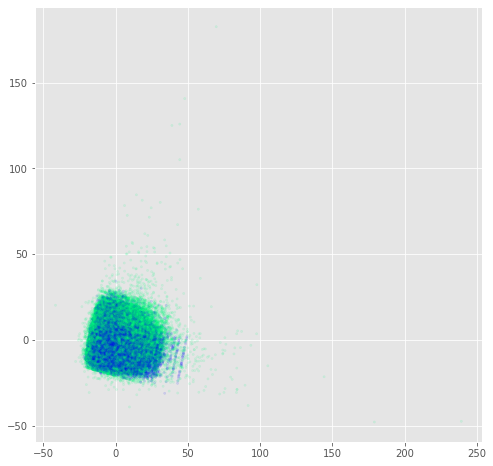

In [32]:
existing_interaction_pairs = train_X_curr_excluded_from_average
non_existing_interaction_pairs = train_X_averages_with_curr_bc_unseen
train_X_seen = train_X_curr_excluded_from_average
train_X_unseen = train_X_averages_with_curr_bc_unseen
train_y_seen = train_y_curr_excluded_from_average
train_y_unseen = train_y_averages_with_curr_bc_unseen

train_dataset_size = len(existing_interaction_pairs)+len(non_existing_interaction_pairs)
train_dataset_indexer = np.arange(train_dataset_size)
np.random.shuffle(train_dataset_indexer)

train_X = np.vstack((train_X_curr_excluded_from_average,train_X_averages_with_curr_bc_unseen))
train_y = np.hstack((train_y_curr_excluded_from_average,train_y_averages_with_curr_bc_unseen))

train_X = train_X[train_dataset_indexer]
train_y = train_y[train_dataset_indexer]
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.25)


pca = PCA(2)
temp_X_pca_input = train_X
temp_y_pca_input = train_y

Z = pca.fit_transform(temp_X_pca_input)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Z[:,0], Z[:,1],c=temp_y_pca_input, alpha=0.1, s=5, cmap="winter")

(2.0, 0)

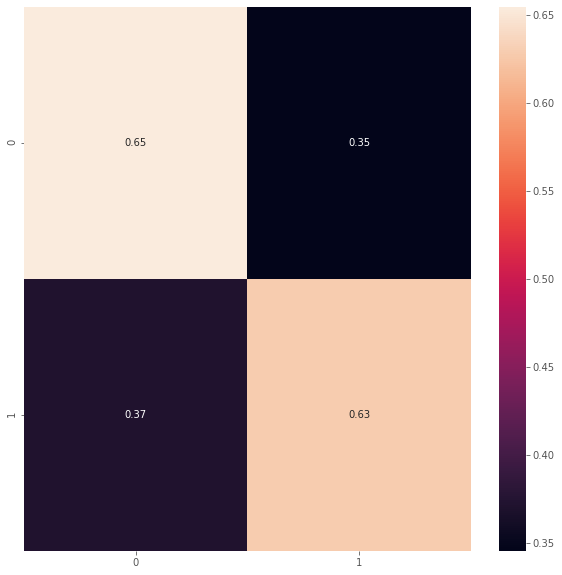

In [33]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=800, class_weight="balanced")
log_reg.fit(X_train, y_train)
#X_val = ss.transform(X_val)
lr_y_pred = log_reg.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax2 = plt.subplots(figsize=(10,10)) 
ax2 = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax2.get_ylim()
ax2.set_ylim(sum(y_lims), 0)

In [ ]:
model = Sequential()
model.add(Dense(50, input_shape=(train_X.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=100)

Epoch 1/5
 178/1242 [===>..........................] - ETA: 2s - loss: 0.6624 - accuracy: 0.5838